In this lab we consider the same learning setting as in Lab 1, but now we will apply different decentralized algorithms from Lecture 4. This allows us to illustrate several performance trade-offs, that will be analyzed in detail in Lecture 5. These are reproduced from slides 36 of Lecture 5 onwards, although this lab can be completed already following Lecture 4 if desired. This will provide a preview of the material covered in Lecture 5. As in Lab 2, we begin by importing some standard libraries. We also set the random seed for consistency of the results, although this can be removed freely.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

We set the parameters for the distributions of features, noise and model, as well as the iteration count, number of experiments to average over, dimension of the linear model and number of agents. The parameters in this cell are the ones we will be primarly varying to obtain numerical results in different settings.

We also set the base model to the vector of all ones.

We also generate a set of weights $w_k^o$, along with the corresponding globally optimal model $w^o$. It can be verified that, since the regressor covariances $R_h$ are common across agents, it holds that $w^o = \frac{1}{K} \sum_{k=1}^K w_k^o$.

Finally, we set the step-size.

You are encouraged to vary these parameters and see if the numerical results conform with the analytical results in the lectures.

In [28]:
sigma_h_squared = 1
sigma_v_squared = 0.1
sigma_w_squared = 0.1
iterations = 500
experiments = 10

M = 2
K = 10

w_base = np.ones(M)
w = np.random.multivariate_normal(w_base, np.square(sigma_w_squared)*np.eye(M), K).T
w_star = np.mean(w, 1)

mu = 0.1


Now we generate an Erdos-Renyi graph as described on Slide 50 of Lecture 3. 

We construct the combination matrix $A$ from $C$ by following the Metropolis rule from Slide 20 of Lecture 3.

Note that by construction, an Erdos-Renyi graph does not need to be connected. Indeed, particularly for small edge connection probabilities, it is rather likely to end up with a disconnected. From the Perron-Frobenius Theorem we know that, if a graph is connected, it will have a single eigenvalue at $1$. We can exploit this fact to check whether a graph is connected by computing the eigendecomposition of its adjacency matrix, and evaluating the eigenvalue with the second-largest magnitude. We simply keep generating Erdos-Renyi graphs until we arrive at a connected graph.

In [29]:
p_edge = 0.1

lambda_2 = 1
while lambda_2 > 0.99999999:
    C = np.eye(K)
    for k in range(K):
        for l in range(k+1, K):
            connected = np.random.binomial(1, p_edge)
            if connected == 1:
                C[l, k] = 1
                C[k, l] = 1

    n = C@np.ones((K,))

    A = np.zeros((K, K))
    for k in range(K):
        for l in range(k+1, K):
            if C[k, l] == 1:
                A[k, l] = np.true_divide(1, np.max([n[k], n[l]]))
                A[l, k] = A[k, l]

    degrees = A@np.ones((K,))
    for k in range(K):
        A[k, k] = 1 - degrees[k]

    eigs = np.linalg.eigvalsh(A)
    lambda_2 = eigs[-2]
print(lambda_2)


0.9451725804852645


We are now ready to implement the distributed gradient descent, diffusion, Exact diffusion and the Aug-DGM algorithm. All of these are derived in Lecture 4.

In [30]:
# For DGD, we only need to maintain the weights. We store them across iterations and experiments to later analyze the learning dynamics, but this is not necessary.
w_dgd = np.zeros((M, K, iterations, experiments))

# For diffusion, we initialize weights for the intermediate weights following the gradient update, as well as the actual weights.
w_dif = np.zeros((M, K, iterations, experiments))
psi_dif = np.zeros((M, K, iterations, experiments))

# For EXTRA, we also add a variable to implement the correction term.
w_exact = np.zeros((M, K, iterations, experiments))
psi_extra = np.zeros((M, K, iterations, experiments))
phi_exact = np.zeros((M, K, iterations, experiments))

# For gradient we need to maintain a gradient tracking variable in a addition to the weights. Additionally, we will want to store previously computed gradients for one iteration in order to update the tracking variable.
w_tracking = np.zeros((M, K, iterations, experiments))
psi_tracking = np.zeros((M, K, iterations, experiments))
inter_tracking = np.zeros((M, K, iterations, experiments))
g_tracking = np.zeros((M, K, iterations, experiments))

old_gradient = np.zeros((M, K))
new_gradient = np.zeros((M, K))


error_dgd = np.zeros((K, iterations, experiments))
error_dif = np.zeros((K, iterations, experiments))
error_extra = np.zeros((K, iterations, experiments))
error_tracking = np.zeros((K, iterations, experiments))


# We also initialize arrays that will store the realizations of $h$, $v$, and $\gamma$ to use the same realizations across different algorithms.
h = np.zeros((M, K))
v = np.zeros((K, 1))
gamma = np.zeros((K, 1))

for run in range(experiments):
    # With bias-corrected algorithms, some care needs to be taken with the very first iteration. This is because the correction variable in the case of Exact diffusion, and tracking variable in the case of Aug-DGM need to be intialized in a very particular way. 
    for k in range(K):
        h[:, k] = np.random.multivariate_normal(np.zeros(M), sigma_h_squared*np.eye(M))
        v[k] = np.random.normal(0, sigma_v_squared)
        gamma[k] = np.matmul(h[:, k].T, w[:, k]) + v[k] 

    # Distributed gradient descent
    # The first step of DGD is standard
    for k in range(K):
        for l in range(K):
            w_dgd[:, k, 1, run] += A[l, k] * w_dgd[:, l, 0, run]
    for k in range(K):
        w_dgd[:, k, 1, run] += mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dgd[:, k, 0, run]))
    
        error_dgd[k, 0, run] = np.square(np.linalg.norm(w_dgd[:, k, 0, run] - w_star))
        error_dgd[k, 1, run] = np.square(np.linalg.norm(w_dgd[:, k, 1, run] - w_star))
    
    # Diffusion
    # The first step of Diffusion is standard
    for k in range(K):
            psi_dif[:, k, 1, run] = w_dif[:, k, 0, run] + mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dif[:, k, 0, run]))
        
    for k in range(K):
        for l in range(K):
            w_dif[:, k, 1, run] += A[l, k] * psi_dif[:, l, 1, run]
        error_dif[k, 0, run] = np.square(np.linalg.norm(w_dif[:, k, 0, run] - w_star))
        error_dif[k, 1, run] = np.square(np.linalg.norm(w_dif[:, k, 1, run] - w_star))

    # Exact diffusion
    # Initializing w and psi to zero causes the very first step of Exact diffusion to concide with the very first step of the classical diffusion algorithm (see slide 29 of Lecture 4).
    for k in range(K):
            psi_extra[:, k, 1, run] = w_exact[:, k, 0, run] + mu * h[:, k] * (gamma[k] - np.dot(h[:, k], w_exact[:, k, 0, run]))
            phi_exact[:, k, 1, run] = psi_extra[:, k, 1, run] 

    for k in range(K):
        for l in range(K):
            w_exact[:, k, 1, run] += A[l, k] * phi_exact[:, l, 1, run]
        error_extra[k, 0, run] = np.square(np.linalg.norm(w_exact[:, k, 0, run] - w_star))
        error_extra[k, 1, run] = np.square(np.linalg.norm(w_exact[:, k, 1, run] - w_star))

    # AugDGM
    # As is typical in dynamic consensus algorithms, we initialize g to the quantity we are trying to track, which in this case corresponds to the local gradients.
    for k in range(K):
        g_tracking[:, k, 0, run] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, 0, run])) 
        psi_tracking[:, k, 1, run] = w_tracking[:, k, 0, run] - mu * g_tracking[:, k, 0, run]
    for k in range(K):
        for l in range(K):
            w_tracking[:, k, 1, run] += A[l, k]*psi_tracking[:, l, 1, run] 
    for k in range(K):
        old_gradient[:, k] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, 0, run]))  
        h[:, k] = np.random.multivariate_normal(np.zeros(M), sigma_h_squared*np.eye(M))
        v[k] = np.random.normal(0, sigma_v_squared)
        gamma[k] = np.matmul(h[:, k].T, w[:, k]) + v[k]  
        new_gradient[:, k] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, 1, run]))  
        inter_tracking[:, k, 1, run] = g_tracking[:, k, 0, run] + new_gradient[:, k] - old_gradient[:, k]
    for k in range(K):
        for l in range(K):
            g_tracking[:, k, 1, run] += A[l, k]*inter_tracking[:, l, 1, run] 

        error_tracking[k, 0, run] = np.square(np.linalg.norm(w_tracking[:, k, 0, run] - w_star))
        error_tracking[k, 1, run] = np.square(np.linalg.norm(w_tracking[:, k, 1, run] - w_star))

    # Having taken care of the unique first step, we can proceed iterating from 2 for as many iterations as we like.
    for i in range(2, iterations):
        for k in range(K):
            h[:, k] = np.random.multivariate_normal(np.zeros(M), sigma_h_squared*np.eye(M))
            v[k] = np.random.normal(0, sigma_v_squared)
            gamma[k] = np.matmul(h[:, k].T, w[:, k]) + v[k] 

        # Diffusion
        for k in range(K):
            psi_dif[:, k, i, run] = w_dif[:, k, i-1, run] + mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dif[:, k, i-1, run]))
        
        for k in range(K):
            for l in range(K):
                w_dif[:, k, i, run] += A[l, k] * psi_dif[:, l, i, run]
            error_dif[k, i, run] = np.square(np.linalg.norm(w_dif[:, k, i, run] - w_star))

        # Distributed Gradient Descent
        for k in range(K):
            for l in range(K):
                w_dgd[:, k, i, run] += A[l, k] * w_dgd[:, l, i-1, run]
        for k in range(K):
            w_dgd[:, k, i, run] += mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_dgd[:, k, i-1, run]))
            error_dgd[k, i, run] = np.square(np.linalg.norm(w_dgd[:, k, i, run] - w_star))

        # Exact diffusion
        for k in range(K):
            psi_extra[:, k, i, run] = w_exact[:, k, i-1, run] + mu * h[:, k]*(gamma[k] - np.dot(h[:, k], w_exact[:, k, i-1, run]))
            phi_exact[:, k, i, run] = w_exact[:, k, i-1, run] + psi_extra[:, k, i, run] - psi_extra[:, k, i-1, run]

        for k in range(K):
            for l in range(K):
                w_exact[:, k, i, run] += A[l, k] * phi_exact[:, l, i, run]
            error_extra[k, i, run] = np.square(np.linalg.norm(w_exact[:, k, i, run] - w_star))

        # AugDGM
        for k in range(K):
            psi_tracking[:, k, i, run] = w_tracking[:, k, i-1, run] - mu * g_tracking[:, k, i-1, run]
        for k in range(K):
            for l in range(K):
                w_tracking[:, k, i, run] += A[l, k]*psi_tracking[:, l, i, run] 
        for k in range(K):
            old_gradient[:, k] = new_gradient[:, k]
            new_gradient[:, k] = - h[:, k]*(gamma[k] - np.dot(h[:, k], w_tracking[:, k, i, run]))  
            inter_tracking[:, k, i, run] = g_tracking[:, k, i-1, run] + new_gradient[:, k] - old_gradient[:, k]
        for k in range(K):
            for l in range(K):
                g_tracking[:, k, i, run] += A[l, k]*inter_tracking[:, l, i, run] 

            error_tracking[k, i, run] = np.square(np.linalg.norm(w_tracking[:, k, i, run] - w_star))
        

Finally, we generate the learning curves and plot.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


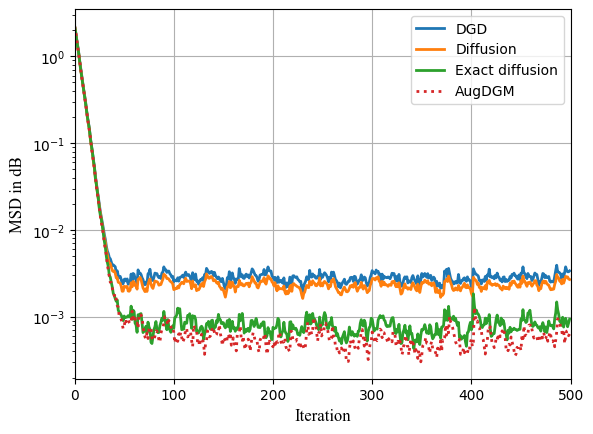

In [31]:
 
learning_curve_ci = np.mean(np.mean(error_dgd, axis=2), axis=0)
learning_curve_dif = np.mean(np.mean(error_dif, axis=2), axis=0)
learning_curve_extra = np.mean(np.mean(error_extra, axis=2), axis=0)
learning_curve_tracking = np.mean(np.mean(error_tracking, axis=2), axis=0)
plt.figure()
plt.semilogy(range(iterations), learning_curve_ci, linewidth=2, label='DGD')
plt.semilogy(range(iterations), learning_curve_dif, linewidth=2, label='Diffusion')
plt.semilogy(range(iterations), learning_curve_extra, linewidth=2, label='Exact diffusion')
plt.semilogy(range(iterations), learning_curve_tracking, ':', linewidth=2, label='AugDGM')
plt.xlabel('Iteration',fontsize=12,fontname='times new roman')
plt.ylabel('MSD in dB',fontsize= 12,fontname='times new roman' )
plt.xlim(0,iterations)
plt.legend()
plt.grid()
plt.savefig('out.eps', format='eps')
plt.show()